In [29]:
import pandas as pd
import numpy as np
from plot_cdf import plot_cdf, plot_cdf_multiple
import matplotlib.pyplot as plt
import json
import os
import glob

## Analyze output from mp_train_test_one_trace


In [30]:
# conf_name = "SAC_WIRED_900kbps_200_delay_False_norm_states_True_tuned_True"
conf_name = "TD3_WIRED_200kbps_200_delay_False_norm_states_True_tuned_False"
# conf_name = "TD3_WIRED_35mbps_200_delay_False_norm_states_True_tuned_True"
# conf_name = "TD3_4G_500kbps_200_delay_False_norm_states_True_tuned_True"
# conf_name = "TD3_4G_700kbps_200_delay_True_norm_states_True_tuned_False"
# conf_name = "TD3_4G_3mbps_200_delay_False_norm_states_True_tuned_True"

In [31]:
prefix = "../output_mp/rates_delay_loss_"
suffix = ".pickle"

pickle_path = prefix+conf_name+suffix
print(pickle_path)
l_rate = pd.read_pickle(pickle_path)
time_step = int(pickle_path.split("/")[2].split("_")[6])
print(time_step)
REAL_NAME = pickle_path.split("/")[2].split("_")[4] + "_" + pickle_path.split("/")[2].split("_")[5]
print(REAL_NAME)

pickle_path_gcc = f"../apply_model/results_gcc/rates_delay_loss_gcc_{REAL_NAME}.pickle"
l_rate_gcc = pd.read_pickle(pickle_path_gcc)
trace_name = l_rate_gcc["trace_name"]
print(trace_name)

pickle_path_hrcc = f"../apply_model/results_hrcc/rates_delay_loss_hrcc_{REAL_NAME}.pickle"
l_rate_hrcc = pd.read_pickle(pickle_path_gcc)

../output_mp/rates_delay_loss_TD3_WIRED_200kbps_200_delay_False_norm_states_True_tuned_False.pickle
200
WIRED_200kbps
WIRED_200kbps


In [38]:
for key in l_rate.keys():
    print(len(l_rate[key]))

10


Trace: ./traces/WIRED_200kbps.json


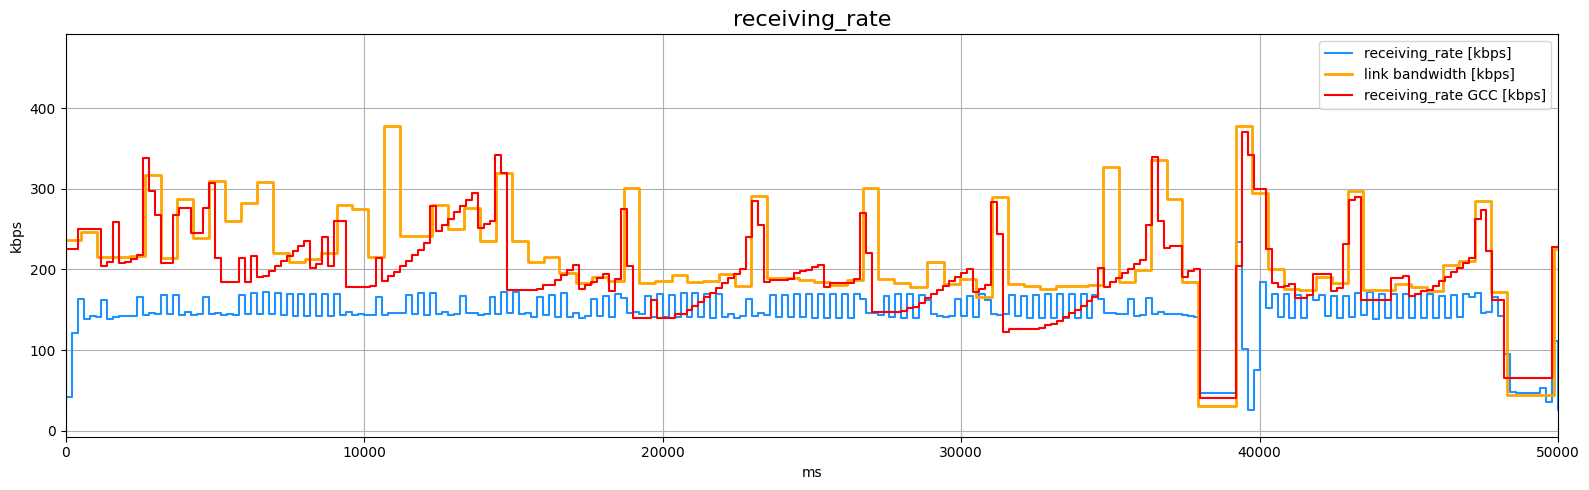

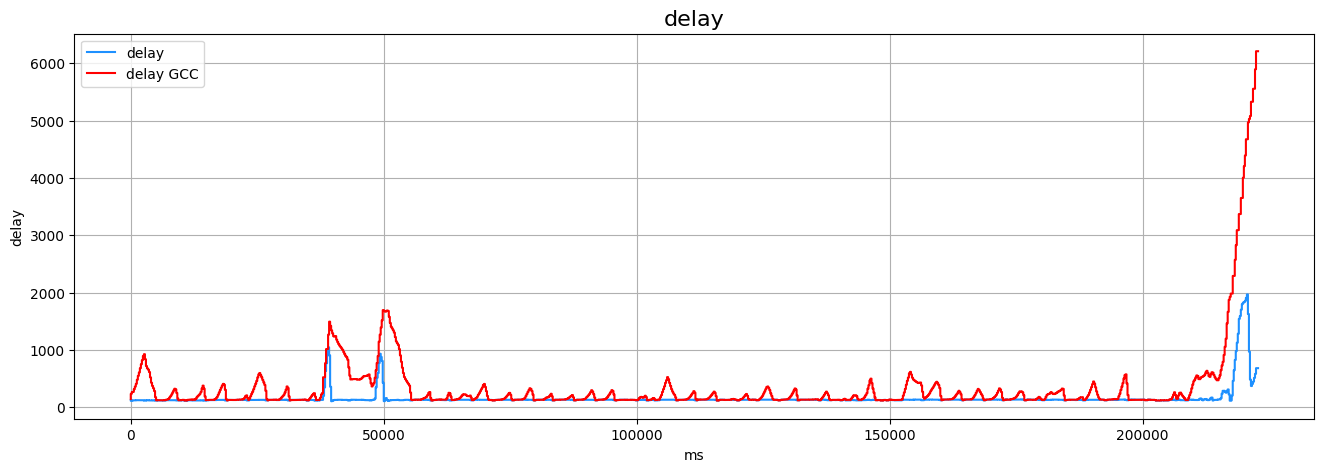

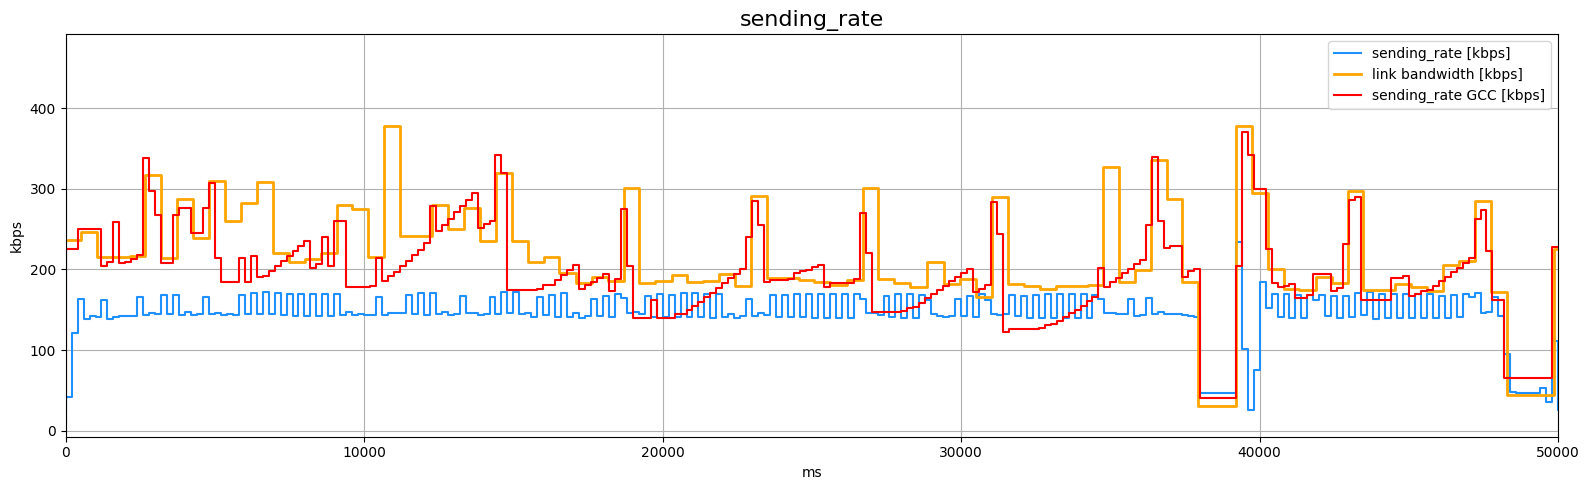

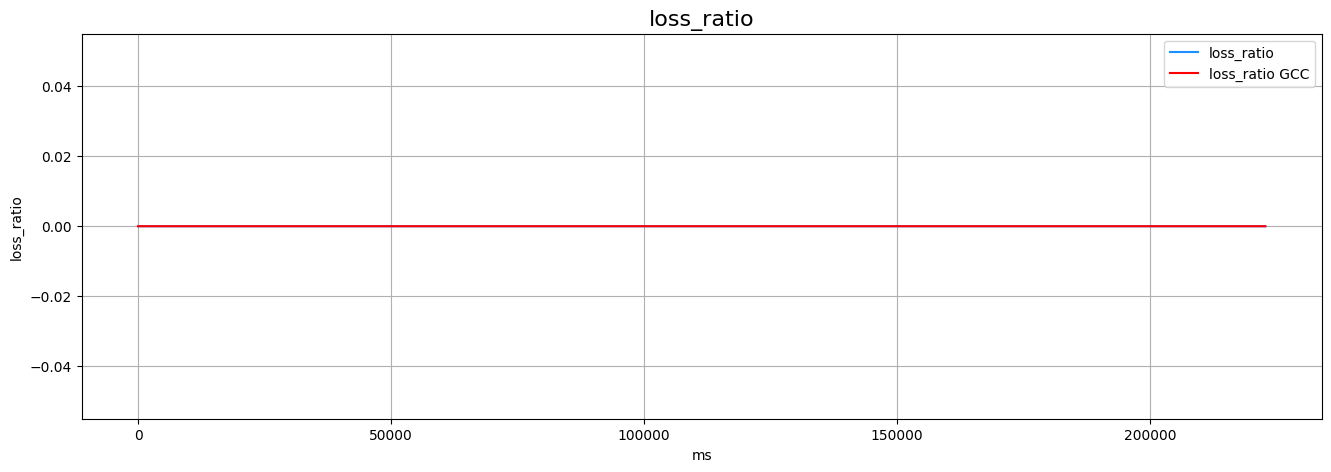

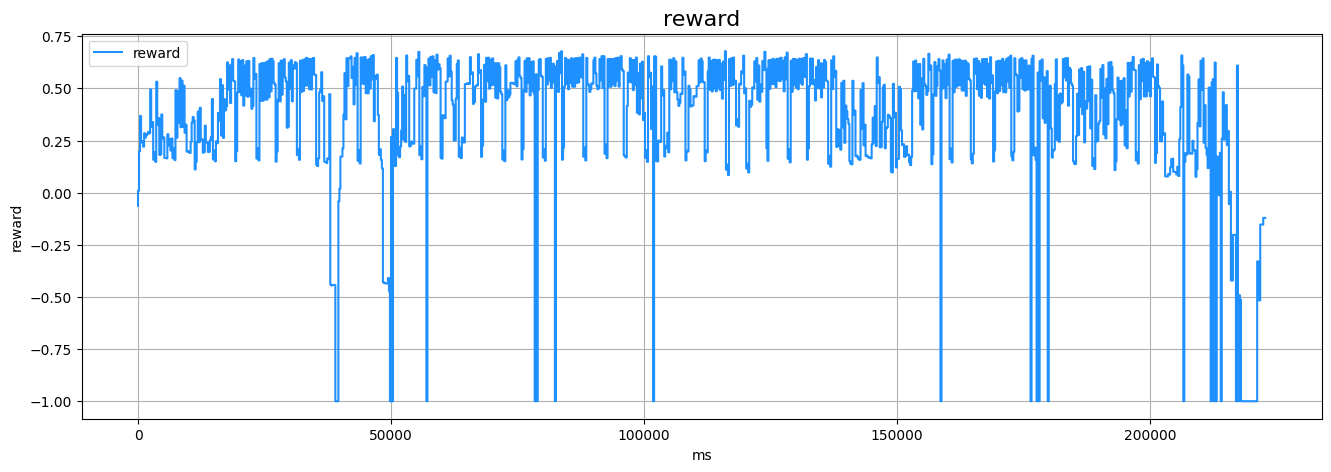

In [35]:
m = 9
plot_gcc = True
plot_hrcc = False

for key in l_rate.keys():
    
    print(f"Trace: {key}")
    colors = iter(["dodgerblue", "teal", "indianred", "olive", "yellow", "green"])

    # for metric in ["bandwidth_prediction", "receiving_rate", "sending_rate", "delay", "loss_ratio", "reward"]:
    for metric in ["receiving_rate", "delay", "sending_rate", "loss_ratio", "reward"]: #reward
        #Define capacity

        trace_name = key
        trace_name = "../" + trace_name.split("/")[1] + "/" + trace_name.split("/")[2]

        with open(trace_name, "r") as f:
            d = json.load(f)

        df = pd.DataFrame(d["uplink"]["trace_pattern"])
        time = [0] + list(df["duration"].cumsum())
        capacities = [df["capacity"].iloc[0]] + list(df["capacity"])
        

        df_rate = pd.DataFrame(l_rate[key][m][metric], columns=[metric])
        if plot_gcc and (metric != "reward"):
            df_rate_gcc = pd.DataFrame(l_rate_gcc[metric], columns=[metric])
            df_rate = df_rate.join(df_rate_gcc, rsuffix="_gcc")
        if plot_hrcc and (metric != "reward"):
            df_rate_hrcc = pd.DataFrame(l_rate_hrcc[metric], columns=[metric])
            df_rate = df_rate.join(df_rate_hrcc, rsuffix="_hrcc")

        t = np.arange(len(df_rate))*time_step
        df_rate["time"] = t
        df_rate.set_index("time", inplace=True)


        if metric in ["bandwidth_prediction", "sending_rate", "receiving_rate"]:

            plt.figure(figsize=(16,5))
            plt.title(metric, fontsize=16)
            # color=next(colors)
            plt.step(df_rate.index, df_rate[metric]/1000, label=f"{metric} [kbps]", color="dodgerblue")
            plt.step(time, capacities, lw=2, label="link bandwidth [kbps]", color="orange")
            if plot_gcc and (metric != "reward"):
                plt.step(df_rate.index, df_rate[f"{metric}_gcc"]/1000, label=f"{metric} GCC [kbps]", color="red")
            if plot_hrcc and (metric != "reward"):
                plt.step(df_rate.index, df_rate[f"{metric}_hrcc"]/1000, label=f"{metric} HRCC [kbps]", color="green")
            plt.legend()
            plt.ylabel("kbps")
            plt.xlabel("ms")
            plt.grid()
            if REAL_NAME == "WIRED_200kbps":
                plt.xlim((0, 50000))
            if REAL_NAME == "WIRED_35mbps":
                plt.ylim((0, 40000))
            elif REAL_NAME == "4G_700kbps":
                plt.ylim(0, 1500)
            elif REAL_NAME == "4G_3mbps":
                plt.ylim(0,8000)
            elif REAL_NAME == "4G_500kbps":
                plt.ylim(0,1600)
            plt.tight_layout()

        else:
            plt.figure(figsize=(16,5))
            plt.title(metric, fontsize=16)
            plt.step(df_rate.index, df_rate[metric], label=f"{metric}", color="dodgerblue")
            if plot_gcc and (metric != "reward"):
                plt.step(df_rate.index, df_rate[f"{metric}_gcc"], label=f"{metric} GCC", color="red")
            if plot_hrcc and (metric != "reward"):
                plt.step(df_rate.index, df_rate[f"{metric}_hrcc"], label=f"{metric} HRCC", color="green")
            plt.ylabel(metric)
            plt.xlabel("ms")
            plt.legend()
            plt.grid()
            
        plt.show()

## Calculate scores
### TODO: Calculate for GCC as well

##### Be careful of 0 capacity in trace file! - we replace it with a really big number to get U=0, check

In [6]:
def make_bandwidth_series(current_trace, step_time):
    #read bandwidth file and create series
    #index timestamps, values bandwidth
    with open(current_trace, "r") as f:
        d = json.load(f)
    df = pd.DataFrame(d["uplink"]["trace_pattern"])
    time = [0] + list(df["duration"].cumsum())
    capacities = [df["capacity"].iloc[0]] + list(df["capacity"])
    s = pd.Series(index=pd.to_datetime(time, unit="ms"), data=capacities)
    capacities = s.resample(f"{step_time}ms").ffill()
    return capacities

In [7]:
current_trace = "../traces/" + REAL_NAME + ".json"
current_trace

'../traces/WIRED_35mbps.json'

### 1 QoE Utilization - receiving rate

In [8]:
metric = "receiving_rate"

capacities = make_bandwidth_series(current_trace, time_step)

df_rate = pd.DataFrame(l_rate[key][m][metric], columns=[metric])
df_rate_gcc = pd.DataFrame(l_rate_gcc[metric], columns=[metric])
df_rate = df_rate.join(df_rate_gcc, rsuffix="_gcc")

t = np.arange(len(df_rate))*time_step
df_rate["time"] = t
df_rate["time"] = pd.to_datetime(df_rate["time"], unit="ms")
df_rate.set_index("time", inplace=True)

receiving_rate_kbps = df_rate["receiving_rate"]/1000
capacities_kbps = capacities.replace(0, 100000000)

rr_kbps_gcc = df_rate["receiving_rate_gcc"]/1000

U = receiving_rate_kbps / capacities_kbps
U_gcc = rr_kbps_gcc / capacities_kbps

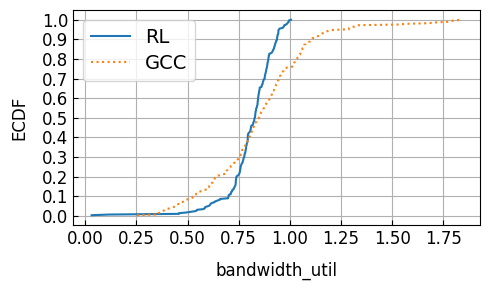

In [24]:
plot_cdf_multiple([U, U_gcc], "bandwidth_util", legend=["RL", "GCC"], figsize=(5,3))
# plt.xlim(0,1)

In [10]:
U_gcc.max(), U.max()

(1.8380099502487561, 1.0054255319148937)

In [11]:
qoe_rr = 100*U.quantile(0.5)
qoe_rr_gcc = 100*U_gcc.quantile(0.5)
print("QoE receiving rate:")
print(f"RL: {round(qoe_rr,2)}, GCC: {round(qoe_rr_gcc,2)}")

QoE receiving rate:
RL: 82.92, GCC: 84.88


### 2 QoE delay

In [12]:
metric = "delay"

df_rate = pd.DataFrame(l_rate[key][m][metric], columns=[metric])
df_rate_gcc = pd.DataFrame(l_rate_gcc[metric], columns=[metric])
df_rate = df_rate.join(df_rate_gcc, rsuffix="_gcc")

t = np.arange(len(df_rate))*time_step
df_rate["time"] = t
df_rate["time"] = pd.to_datetime(df_rate["time"], unit="ms")
df_rate.set_index("time", inplace=True)

delay = df_rate["delay"]
delay_gcc = df_rate["delay_gcc"]

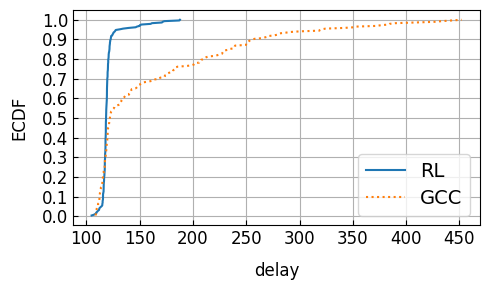

In [13]:
plot_cdf_multiple([delay, delay_gcc], "delay", legend=["RL", "GCC"], figsize=(5,3))
# plt.xlim(0,1)

In [14]:
d_max = delay.max()
d_min = delay.min()
d_95 = delay.quantile(0.95)

d_max_gcc = delay_gcc.max()
d_min_gcc = delay_gcc.min()
d_95_gcc = delay_gcc.quantile(0.95)

In [15]:
#QoE delay has to do with delay variation + magnitude
qoe_delay = 100*(d_max-d_95)/(d_max - d_min)
qoe_delay_gcc = 100*(d_max_gcc - d_95_gcc) / (d_max_gcc - d_min_gcc)

print("QoE delay:")
print(f"RL: {round(qoe_delay,2)}, GCC: {round(qoe_delay_gcc,2)}")

QoE delay:
RL: 69.86, GCC: 38.37


### 3 QoE losses

In [16]:
metric = "loss_ratio"

df_rate = pd.DataFrame(l_rate[key][m][metric], columns=[metric])
df_rate_gcc = pd.DataFrame(l_rate_gcc[metric], columns=[metric])
df_rate = df_rate.join(df_rate_gcc, rsuffix="_gcc")

t = np.arange(len(df_rate))*time_step
df_rate["time"] = t
df_rate["time"] = pd.to_datetime(df_rate["time"], unit="ms")
df_rate.set_index("time", inplace=True)

loss_ratio = df_rate["loss_ratio"]
loss_ratio_gcc = df_rate["loss_ratio_gcc"]

In [17]:
L = loss_ratio.mean()
L_gcc = loss_ratio_gcc.mean()
L, L_gcc

(0.0, 0.0)

In [18]:
qoe_losses = 100*(1-L)
qoe_losses_gcc = 100*(1-L_gcc)

print("QoE losses:")
print(f"RL: {round(qoe_losses,2)}, GCC: {round(qoe_losses_gcc,2)}")

QoE losses:
RL: 100.0, GCC: 100.0


### 4 Overall QoE

In [19]:
qoe = 0.333*qoe_rr + 0.333*qoe_delay + 0.333*qoe_losses
qoe_gcc = 0.333*qoe_rr_gcc + 0.333*qoe_delay_gcc + 0.333*qoe_losses_gcc

print("Overall QoE:")
print(f"RL: {round(qoe,2)}, GCC: {round(qoe_gcc,2)}")

Overall QoE:
RL: 84.18, GCC: 74.34


In [ ]:
#From paper
qoe2 = 0.2*qoe_rr + 0.2*qoe_delay + 0.3*qoe_losses
qoe_gcc2 = 0.2*qoe_rr_gcc + 0.2*qoe_delay_gcc + 0.3*qoe_losses_gcc

print("To compare with HRCC paper: overall QoE:")
print(f"RL: {qoe2}, GCC: {qoe_gcc2}")